In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
#from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import ResNet50
import datetime
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model
import cv2
from PIL import Image
import numpy as np

In [2]:
root_path = os.getcwd()+"\\dataset"
root_path

'D:\\deeplearning\\skin_cancer\\dataset\\dataset'

In [3]:
input_shape = (224,224,3)
input_image = (224,224)

In [4]:
base_model = ResNet50(
    include_top=False,
    input_shape=input_shape,
    weights='imagenet')
base_model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
preds=Dense(3,activation='softmax')(x)

In [6]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:

for layer in model.layers[:35]:
    layer.trainable=False
for layer in model.layers[35:]:
    layer.trainable=True
    
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
batch_size = 32
epochs = 30

base_learning_rate = 1e-3 #0.0001
optimizer = Adam(lr=base_learning_rate, decay=1e-4)

#optimizer = RMSprop(lr=base_learning_rate, decay=1e-4)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
		width_shift_range=0.1,
		height_shift_range=0.1,
		horizontal_flip=True)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        root_path+"/train",
        target_size=input_image,
        batch_size=batch_size,
        class_mode='categorical')


test_generator = train_datagen.flow_from_directory(
        root_path+"/test",
        target_size=input_image,
        batch_size=batch_size,
class_mode='categorical')

Found 2967 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [10]:
def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    lr = lr
    total_epochs = epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.6)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-4
    elif epoch > check_2:
        lr *= 1e-3
    elif epoch > check_3:
        lr *= 1e-2
    elif epoch > check_4:
        lr *= 1e-1

    print("[+] Current Lr rate : {} ".format(lr))
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [12]:

num_train = len(train_generator.filenames)
num_test = len(test_generator.filenames)
steps_per_epoch=int(num_train / batch_size)


In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                            validation_data=test_generator,
                            validation_steps=int(num_test / batch_size), callbacks=[ tensorboard_callback,lr_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
[+] Current Lr rate : 0.0010000000474974513 
Epoch 1/30
 1/92 [..............................] - ETA: 0s - loss: 1.4931 - accuracy: 0.3125WARNING:tensorflow:From c:\users\link\.conda\envs\tharhtet\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
92/92 [==============================] - 31s 340ms/step - loss: 1.1223 - accuracy: 0.5997 - val_loss: 298.0339 - val_accuracy: 0.3313
[+] Current Lr rate : 0.0010000000474974513 
Epoch 2/30
92/92 [==============================] - 29s 320ms/step - loss: 0.7351 - accuracy: 0.6375 - val_loss: 1.4406 - val_accuracy: 0.3938
[+] Current Lr rate : 0.0010000000474974513 
Epoch 3/30
92/92 [==============================] - 30s 321ms/step - loss: 0.6566 - accuracy: 0.6872 - val_loss: 2.6009 - val_a

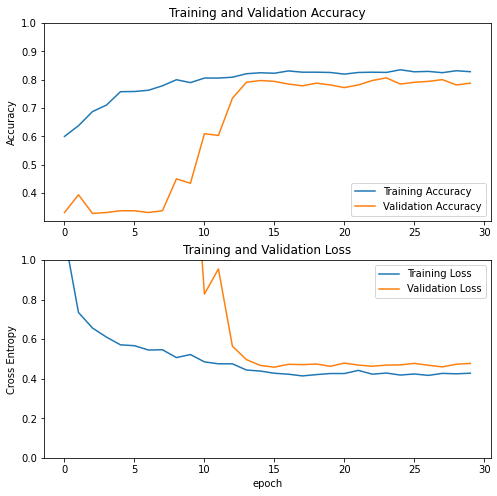

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
model.save("17_8_2020_ep20_lr-1e-3_acc79-6.h5")

In [16]:
train_generator.class_indices

{'Benign keratosis-like lesions': 0, 'Melanocytic nevi': 1, 'Melanoma': 2}

In [4]:
model_path = "17_8_2020_ep20_lr-1e-3_acc79-6.h5"
model =  tf.keras.models.load_model(model_path)

In [5]:
def preprocess_input(x):
    """Preprocesses a tensor encoding a batch of images.

    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.

    # Returns
        Preprocessed tensor. 
    """


    # 'RGB'->'BGR'
    
    x *= (1./255)

    return x

In [6]:
def decode_predictions(preds, top=2, model_json=""):

    CLASS_INDEX = {'0':'Benign keratosis-like lesions', '1':'Melanocytic nevi', '2':'Melanoma'}
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        for i in top_indices:
            each_result = []
            each_result.append(CLASS_INDEX[str(i)])
            each_result.append(pred[i])
            results.append(each_result)

    return results

In [11]:
file_path = r"D:\deeplearning\skin_cancer\dataset\dataset\test\Melanocytic nevi\nv_91.jpg"


read_img = cv2.imread(file_path)
read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
image_input = Image.fromarray(np.uint8(read_img))
image_input = image_input.resize(input_image)
image_input = np.expand_dims(image_input, axis=0)
image_to_predict = image_input.copy()
image_to_predict = np.asarray(image_to_predict, dtype=np.float64)
image_to_predict = preprocess_input(image_to_predict)




classes = model.predict(image_to_predict,batch_size=1)
class_Name = decode_predictions(preds=classes)[0][0]



print("Read Path",file_path)

print("Original Img size : ",read_img.shape)
print(image_input.shape)
print(classes)
print("Predicted One-hot : ",classes)
print("Class Name:",class_Name)

Read Path D:\deeplearning\skin_cancer\dataset\dataset\test\Melanocytic nevi\nv_91.jpg
Original Img size :  (400, 400, 3)
(1, 224, 224, 3)
[[0.56906646 0.19616072 0.23477279]]
Predicted One-hot :  [[0.56906646 0.19616072 0.23477279]]
Class Name: Benign keratosis-like lesions


In [8]:
from tensorflow.python.keras.preprocessing import image
file_path = r"D:\deeplearning\skin_cancer\dataset\dataset\test\Melanoma\mel_96.jpg"

read_img = cv2.imread(file_path)
read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
image_input = Image.fromarray(np.uint8(read_img))
image_input = image_input.resize(input_image)
image_input = np.expand_dims(image_input, axis=0)
image_to_predict = image_input.copy()
image_to_predict = np.asarray(image_to_predict, dtype=np.float64)
image_to_predict = preprocess_input(image_to_predict)

prediction = model.predict(image_to_predict, steps=1)
class_Name = decode_predictions(preds=prediction)
class_Name

[['Benign keratosis-like lesions', 0.6105268], ['Melanoma', 0.38900003]]

In [9]:
file_path = r"D:\deeplearning\skin_cancer\dataset\dataset\test\Melanoma\mel_96.jpg"
read_img = cv2.imread(file_path)
read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
image_input = Image.fromarray(np.uint8(read_img))
image_input = image_input.resize(input_image)
image_input = np.expand_dims(image_input, axis=0)
image_to_predict = image_input.copy()
image_to_predict = np.asarray(image_to_predict, dtype=np.float64)
image_to_predict = preprocess_input(image_to_predict)




classes = model.predict(image_to_predict,batch_size=1)
class_Name = decode_predictions(preds=classes)[0][0]



print("Read Path",file_path)
print("Original Img size : ",read_img.shape)
print("Predicted One-hot : ",classes)
print("Class Name:",class_Name)

Read Path D:\deeplearning\skin_cancer\dataset\dataset\test\Melanoma\mel_96.jpg
Original Img size :  (400, 400, 3)
Predicted One-hot :  [[6.1052680e-01 4.7311286e-04 3.8900003e-01]]
Class Name: Benign keratosis-like lesions


In [10]:
file_path = r"D:\deeplearning\skin_cancer\dataset\dataset\test\Benign keratosis-like lesions\bkl_96.jpg"
read_img = cv2.imread(file_path)
read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
image_input = Image.fromarray(np.uint8(read_img))
image_input = image_input.resize(input_image)
image_input = np.expand_dims(image_input, axis=0)
image_to_predict = image_input.copy()
image_to_predict = np.asarray(image_to_predict, dtype=np.float64)
image_to_predict = preprocess_input(image_to_predict)




classes = model.predict(image_to_predict,batch_size=1)
class_Name = decode_predictions(preds=classes)[0][0]



print("Read Path",file_path)
print("Original Img size : ",read_img.shape)
print("Predicted One-hot : ",classes)
print("Class Name:",class_Name)

Read Path D:\deeplearning\skin_cancer\dataset\dataset\test\Benign keratosis-like lesions\bkl_96.jpg
Original Img size :  (400, 400, 3)
Predicted One-hot :  [[0.6573807  0.00970886 0.33291045]]
Class Name: Benign keratosis-like lesions


In [11]:
test_path = r"D:\deeplearning\skin_cancer\dataset\dataset\testset\test_1"
first_batch_images = []
predicted_labels = []
actual_labels = []


print(os.listdir(test_path))


for temp in os.listdir(test_path):
    temp_path = test_path+"/"+temp
    for current_img in os.listdir(temp_path):
        read_path = temp_path+"/"+current_img
        first_batch_images.append((read_path,current_img)) 
        
        
    
        
        read_img = cv2.imread(read_path)
        read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
        image_input = Image.fromarray(np.uint8(read_img))
        image_input = image_input.resize(input_image)
        image_input = np.expand_dims(image_input, axis=0)
        image_to_predict = image_input.copy()
        image_to_predict = np.asarray(image_to_predict, dtype=np.float64)
        image_to_predict = preprocess_input(image_to_predict)



        classes = model.predict(image_to_predict,batch_size=1)
        class_Name = decode_predictions(preds=classes)[0][0]
        
        actual_labels.append(temp)
        predicted_labels.append(class_Name)

['Benign keratosis-like lesions', 'Melanocytic nevi', 'Melanoma']


In [12]:
from sklearn.metrics import f1_score
test_accuracy = 100 * np.sum(np.array(predicted_labels)==actual_labels) / len(predicted_labels)
print("Test accuracy : {}".format(test_accuracy))


Test accuracy : 73.33333333333333


In [13]:
actual_labels

['Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma']

In [14]:
predicted_labels

['Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Benign keratosis-like lesions',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Melanocytic nevi',
 'Benign keratosis-like lesions',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Benign keratosis-like lesions',
 'Melanoma',
 'Melanoma',
 'Melanoma',
 'Melanocytic nevi']

Confusion matrix, without normalization
[[5 1 1]
 [0 9 1]
 [5 0 8]]


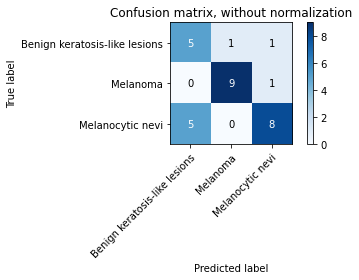

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

unit_label= []
for label in set(actual_labels):
    unit_label.append(label)
unit_label


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax,cm


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
figure,cm = plot_confusion_matrix(predicted_labels, actual_labels, classes=unit_label,
                      title='Confusion matrix, without normalization')

In [19]:
from sklearn.metrics import confusion_matrix


cnf_matrix = cm

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [21]:
TNR

array([0.78, 0.95, 0.88])

In [20]:
ACC

array([0.77, 0.93, 0.77])

In [2]:
fig

NameError: name 'fig' is not defined